# 包引入

In [2]:
from d2l import torch as d2l
import math
import torch
from torch import nn

# chapter 1 : Transformer Encoder的实现
    
    先实现EncoderBlock，
    然后和 Embedding 以及 PositionalEncoding 组合称为Encoder
   

## 一、Encoder Block前的处理

### 1.embedding层

    输入的形状为 B x L, 输出形状为 B x L x num_hiddens
    直接用pytorch自带的nn.Embedding()就可以
    
    不单独写代码了

### 2.位置编码

#### 理解：
        基于三角函数设计的位置编码是模仿数字二进制编码得来的，也就是：
        二进制低位编码数字的变换频率是高于高位的
        同时对于每一列，也随着行数的变化而变化
        虽然对于人类理解起来不太直观，不过只要模型够强大，还是能学习到这种微妙的变化的

#### 形状：
    输入 X
    输出 X + P 
    X和P的形状都是 B x L x num_hiddens
    
    但是这里因为需要有seq_len的max_len，又提前不知道B，所以init的时候P的形状为 1 x maxlen x num_hiddens

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, maxlen=10000): # 有默认值的参数一般放在最后，传参数的时候方便直接不写（如果在中间就不行了）
        """
        num_hiddens和maxlen用于指定位置编码矩阵的形状,maxlen指定输入句子的最长长度，所以一开始就指定了
        dropout就显而易见了，init的时候又要有drouput层
        
        """
        super(PositionalEncoding, self).__init__()
        # drouput
        self.dropout = nn.Dropout(dropout)
        # 先定下P的形状
        self.P = torch.zeros((1, maxlen, num_hiddens))
        # 再填充三角函数值
        # 前半部分形状为 maxlen x 1, 后半部分形状为 1 x num_hiddens/2
        # 整体一除,形状为 maxlen x num_hiddens/2
        X = torch.arange(maxlen, dtype=torch.float32).reshape(-1, 1)/ torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32)/num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
        
    def forward(self, X):
        # 🚩这里的to(X.device)操作有些迷惑，不知道到底什么时候需要传入device了
        # 因为X与新创建的（凭空出现的）数据进行运算了，这种时候一般都得将新数据转到X的device上(还得考虑数据类型)
        # 可以看看后面的数据传入，只要没有新创建的数据加进来，都不需要考虑device
        # 新建的张量需要传入，但是标量好像不用传入，至少作为方法参数的标量不用传入！！
        X = X + self.P[:, X.shape[1], :].to(X.device)
        return self.dropout(X)     

In [4]:
X = torch.arange(8, dtype=torch.float32).reshape(2, 2, 2)
pe = PositionalEncoding(2, 0)
X, pe(X), pe.P.shape

(tensor([[[0., 1.],
          [2., 3.]],
 
         [[4., 5.],
          [6., 7.]]]),
 tensor([[[0.9093, 0.5839],
          [2.9093, 2.5839]],
 
         [[4.9093, 4.5839],
          [6.9093, 6.5839]]]),
 torch.Size([1, 10000, 2]))

## 二、多头自注意力的实现

### 1.sequence_mask
在序列中屏蔽不相关的项目

    🚩 其实只用transformer的话，只是需要输入的valid_lens为一维的，二维的可能用于rnn，
       所以sequence_mask中是有冗余代码的，有时间再整理下冗余代码，将sequence_mask直接并入masked_softmax

In [5]:
import math
import torch
from torch import nn

In [37]:
def sequence_mask(X, valid_lens, value=0):
    """
    X → 必须是一个二维张量，（B， L）/ (B*num_head, L)
    valid_lens → 一维张量，表示每一个句子的有效长度
    value → 用来填充多余位置的value\
    """
    maxlen = X.size(1)
    # 输出是一个bool形数组  形状 B x L
    mask = torch.arange(maxlen, dtype=torch.float32, device=X.device)[None, :] < valid_lens[:, None] 
    # 用value填充不需要的地方
    X[~mask] = value
    return X

In [8]:
# 验证效果
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
valid_lens = torch.tensor([1, 2]) # 必须是tensor， 否则不能使用方法中的升维操作

sequence_mask(X, valid_lens, 0)

tensor([[1, 0, 0],
        [4, 5, 0]])

###  2.masked softmax
    

In [9]:
# masked softmax

def masked_softmax(X, valid_lens):
    """
    X → 三维 Batch_size(几个句子) L L （后两个维度表示一个attention matrix）
    valid_lens → 一维（最常见的场景，一个batch里每个句子有自己各自的长度）Batch_size / 
                  二维（没见过，不理解，每个句子的每个单词的向量表示都有不同长度？） Batch_size x L(sequence_Len)
    """
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        # 保留形状恢复X
        shape = X.shape
        # 为了使用sequence_mask, X需要展成二维的 BL x L， valid_lens需要变成一维的BL
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # -1e6的自然指数就可以当作0了，同时X被展成BL x L
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, -1e6)
        X = X.reshape(shape)
        return nn.functional.softmax(X, dim=-1)

In [10]:
# 验证效果
masked_softmax(torch.rand(2, 4, 4), torch.tensor([2, 3]))

tensor([[[0.3207, 0.6793, 0.0000, 0.0000],
         [0.6715, 0.3285, 0.0000, 0.0000],
         [0.4910, 0.5090, 0.0000, 0.0000],
         [0.3532, 0.6468, 0.0000, 0.0000]],

        [[0.3831, 0.3992, 0.2177, 0.0000],
         [0.2863, 0.3442, 0.3694, 0.0000],
         [0.4003, 0.2702, 0.3295, 0.0000],
         [0.3123, 0.3479, 0.3398, 0.0000]]])

### 3.DotProductAttention
实现了self-attention的核心功能：

attention_weights的计算和并将其和V相乘得到“裸”Output

🚩 注意：
    
    这里DotProduct的实现支持各种形状的attention_matrix，不光是 seq_len x seq_len
    这就为后面decoder的预测输出提供了便利，因为：
        预测第t+1个输出的情况下，
        masked multi-head attention的keys和values是前t-1个输出结果的嵌入表示，形状（t-1， num_hiddens)
        queries是第t个输出的嵌入表示，形状（1， num_hiddens)
        这种情况下使用的DotProduct中的attention_matirx形状就是 （1， t-1），也是支持的！
        
        plus：
        整个decoder走过一遍之后，输出的形状和第t个输出的形状一样，也是（1， num_hiddens）

In [11]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens=None):
        """
        输入的QKV均为 B x L x num_hidden
        valid_lens因为是直接送入mask_softmax的，所以形状也可以为二维或者一维，
        """
        d = queries.shape[-1]
        # scores是没有经过softmax的注意力矩阵
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # 暂退法防止过拟合, 至于为什么用在这个位置，记住之后，多多体会
        return torch.bmm(self.dropout(self.attention_weights), values)

### 4.Multi-Head self attention

#### 4.1 不加multi-head的self attention
如果不涉及多头，那么self-attention有以下流程：

> 输入Input(B, L, num_hidden)乘以 Wq Wk Wv(num_hidden, num_hidden)变成 Q K V，

> 然后使用DotProduct,输入QKV，输出O

> O乘以W_o,得到Output

但是我们要实现的是 Multi-Head-self attention。

#### 4.2 如何加上multi-head
#####  首先分析多头自注意力的输入和输出形状：
    因为输出要concat，所以输出形状肯定是 (Batch_size, seq_len, num_heads, 隐藏层维度)
    
    但是计算注意力的话，seq_len和隐藏层两个维度肯定是要挨着的，又因为要并行计算，所以num_heads维度要往上调整
    那么输入形状就应该是 (Batch_size, num_heads, seq_len, num_hiddens或者num_hiddens/num_heads)
    最后不确定是num_hiddens/num_heads还是num_hiddens,不过李沐用的这个，就跟着用吧，gpt用的好像也是这个
    
##### DotProduct不支持四维输入：
    DotProduct输入的QKV的形状是三维的B x L x num_hidden，而多头自注意力的输入为四维 (Batch_size, num_heads, seq_len, num_hiddens/num_heads)

    怎么办呢？
    
    将num_heads先并到Batch_size维度里面（valid_lens也得跟着进行插值操作，以保证对的上），这些就可以直接用DotProduct了
    之后再将DotProduct的输出分解为四维的 (Batch_size, num_heads, seq_len, 隐藏层维度)
    
    当然，上面对于输入维度进行调整的想法都只是直觉，这样利用DotProduct实现的是否最终是我们要的多头并行计算呢？这还得仔细想想才能明白。
    画画输入的形状图就知道了，懒得讲了！
    
    搞定！
    
#### 4.2 multi-head self-attention的实现流程：
> 输入Input(B, L, num_hidden)乘以 Wq Wk Wv(num_hidden, num_hidden)变成 Q K V，

> 将QKV均转化为三维形状 (Batch_size* num_heads, seq_len, num_hiddens/num_heads) 🚩transpose_qkv方法

> 将转化后的QKV输入DotProductAttention

> 将DotProductAttention的输出转化为四维形状 (Batch_size, num_heads, seq_len, num_hiddens/num_heads) ，然后concat得到三维输出O (B, seq_len, num_hiddens)  🚩transpose_output方法  (不将W_o并入是因为还要传入W_o参数，麻烦，transopose方法中进行的全是不需要W的操作！num_heads不得不传入了）

> O乘以W_o,得到Output

In [12]:
# 先实现两个transpose方法
# 两个方法都无法从X中分辨出num_heads,所以都要传入

def transpose_qkv(X, num_heads):
    # 分割num_hiddens
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    # 交换维度
    X = X.permute(0, 2, 1, 3)
    # 合并batch_size和num_heads维度
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    # 分割batch
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    # 交换维度
    X = X.permute(0, 2, 1, 3)
    # concat
    return X.reshape(X.shape[0], X.shape[1], -1)

In [13]:
# 实现多头自注意力机制
class MultiHeadAttention(nn.Module):
    # 因为初始化时需要定义网络结构，包括W，所以需要size和num_hiddens,包括DotProductAttention，它需要传入dropout参数，所以这里也要传入
    # 所以为什么其它的功能要用方法实现，而这里的DotProductAttention要用class实现的，就是因为其中有网络结构！
    # 并且，多头自注意力，有几个头总不能在forward的时候再传入吧，直接使用模型的人哪里知道你有几个头
    # 🚩三个size可以直接用num_hiddens
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        # 保留，留着forward方法用。为什么不在forward的时候传入？？方法同上
        self.num_heads = num_heads
        # dropout和self_attention用的方法
        self.attention = DotProductAttention(dropout)
        # 四个可学习的W，因为使用的是DotProduct，所以只有这四个可学习的参数
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
    def forward(self, queries, keys, values, valid_lens):
        """
            queries, keys，values 必须分开传入：
                可能看到编码器中三者都相同，
                但是在解码器中也有Multi-head attention,
                它的三个传入就不同
        """
        # 转化成DotProduct可以处理的形状
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        # valid_lens形状改变
        if valid_lens is not None:
            # 不管一维还是二维，都在dim0复制  （目前只能理解一维的）
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        # DotProduct处理
        output = self.attention(queries, keys, values, valid_lens)
        # 直接得到concat后的output(当然前面还有其它操作)
        output_concat = transpose_output(output, self.num_heads)
        # 乘以W_o
        return self.W_o(output_concat)

In [14]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [15]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

🚩🚩 有时间一定把这个MultiHeadAttention改成纯MultiHeadSelfAttention!

🚩 那gpt这些模型中的单次最大输入token是哪里规定的呢？？

上面的方法好像除了Positional Encoding传入了maxlen,其它都没有传入参数/有相关限制， 难道在tokenizer中规定的?先继续往后看吧。
   哈哈哈哈果然，刚问了gpt,说gpt2模型的最大token数主要由Positional Encoding限制。
   当然，这只是技术上的限制，本质的原因还是transformer模型的计算复杂度与输入token的数量n成平方，O(n^2)，n设置太大的话时间和内存都顶不住。
   当我们想对一个模型进行训练或者推理的时候，都会指定最小显存。如果max_len不指定的话，那吃的显存可能无限大，所以必须得规定一个max_token,最小显存可能就是对应的max_token的情况下使用的显存。

## 三、EncoderBlock中的其它模块的实现

    一个EncoderBlock的组成其实主要是
        一个Multi-head self attention + 一个全连接（将num_hiddens映射到num_hiddens）
    这个全连接层不叫全连接，而是叫PositionwiseFFN，为什么呢？
        一般全连接输入的形状为 batch_size x input_dim,输出形状为 batch_size x output_dim
        但是MultiHeadAttention的输出维度为 Batch_size x Seq_len x num_hiddens
        就需要把seq_len集成到第0维或者第二维，但是如果继承到第二维，就要求seq_len是不可变的,
        所以只能把seq_len集成到了batch_size的维度，效果上就是对每句话的每个词的表示都做个一次FCN
        
        不过上面说的这些直接用nn.Linear就可以实现，因为它的输入可以是三维的，但它只看最后一维！
        
        只是这里FCN不叫FCN，而是FFN，因为它有两个全连接和一个relu
        PositionWise中的position就是指句子中的每一个单词
        
        
    EncoderBlock又采用了残差网络的思想，得有add块，同时在add块中集成上normalization
    (因为seq_len维度相当于Channel维度，但是channel固定，seq_len却不是固定的，所以只能用LayerNorm)
    
    
    所以最后EncoderBlock结构就是：
        MultiHeadAttention → Add&norm → PositionwiseFFN → Add&norm

### 1. PositionwiseFFN

基于位置的前馈网络
    
    输入X形状 → B x Seq_len x num_hiddens
    
    输出形状  → 相同

In [16]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_output, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        # relu和dropout一样，会作用域每一个元素，不管多少维
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_output)
        
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

### 2.Add & norm

In [17]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    def forward(self, X, Y):
        # Y是经过上一个模块处理得到的，X是未经处理的
        # AddNorm里有dropout,位置编码里也有dropout,多头自注意力中也有dropout,只有FFN中没有，好！
        return self.ln(self.dropout(Y) + X)

## 四、EncoderBlock的实现

In [18]:
"""
    参数解释：
    三个size用于初始化multi-head attention
    三个ffn用于初始化ffn
    num_hiddens, num_heads就不用说了
    dropout好多地方用得到
    norm_shape有点意料之外，这样理解：
        你想当然认为应该是[seq_len, num_hiddens],觉得这样只传入一个seq_len就好了。
        但是不排除有人就指向以一个词语的嵌入表示作为一片进行性layernorm，这样输入就只是一个[num_hiddens]了
        所以norm_shape需要通过形状告诉addnorm层我想进行的到底是什么。
        🚩 但是啊但是，seq_len怎么会在初始化的时候传入呢？？
            如果传入了[seq_len，num_hiddens], 那么seq_len要怎么指定呢？肯定不能少于maxlen,大概就是maxlen，
            这样的话，Encoder的每次输入的句子都必须是maxlen了，这是对计算资源的一种极大浪费啊

            所以可以看到后面的norm_shape都只是[num_hiddens], 可能就是考虑到这种浪费吧

            那么不就注定了，Encoder中的layernorm的normalized_shape只能是它了吗？？

            所以还传入norm_shape干嘛，直接用num_hiddens不就可以了？？
            难道是为了保持灵活性？
            不懂，全部看完之后再说吧。
            
            结论：应该是代码冗余了，传入的norm_shape只能是num_hiddens
        """
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [19]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

## 五、TransformerEncoder的实现

In [20]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        # 1.记录作用,当我之后要组织数据输入的时候，知道数据要嵌入的维度
        # 2.后面embedding后缩放用得到
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                                            norm_shape, ffn_num_input, ffn_num_hiddens,
                                            num_heads, dropout, use_bias))
    def forward(self, X, valid_lens, *args):
        # 因为embedding后的特征嵌入太小了，都小于1，pos_encoding添加的三角函数值在-1，1范围内
        # 所以要乘一个大数，突出下embedding信息
        # 在DotProduct那里除以 sqrt(num_hiddens)是防止num_hiddens过大，点击结果过大
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        
        # 保存num_layers个attention_matrix
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            # 第一个attention是MultiHeadAttention对象，第二个是DotProductAttention对象
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [21]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

# Chapter2 : TransformerDocoder的实现
    
    

## 一、重要思考

### 1.两个自注意力 & 预测的流程
    DecoderBlock里有两个看似不一样的自注意力块：
        Masked Multi-Head Attention 和 encoder-decoder/cross multi-head attention
    其实这两个块并不用单独实现，还是用之前的Multi-head Attention就可以，改变输入就可以！
    毕竟类定义的时候并没有传入seq_len，传入seq_len不同的QKV只是Attention_matrix形状不一样罢了(seq_q x seq_k)，
    只要保持B和num_hiddens对的上，keys和values形状一样，就可以了。
    
    而且还有一点要意识到：Multi-Head Attention的输出形状是和query的形状一样的。
    
    cross输入的keys和values是encoder的输出 B x seq_len x num_hiddes, valid_len就是encoder输入的encoder，形状B
    masked输入的keys和values比较复杂，要分预测和训练两种情况：
        
        预测情况下：
        当预测第t+1个词的时候，用第t个词的嵌入表示做query,用前t个词的嵌入做keys和values
        decoderblock总共有num_layers个，索引为i
            i=1，keys和values为前t个词的嵌入表示 形状 t x num_hiddens
            i!=1, keys和values就不是经过embedding的嵌入了，而是这些嵌入经过前i-1个块处理过后的中间状态，形状也是（t, num_hiddens）
                但是这中间状态不是直接一下得到的，而是
                预测前t-1个词的过程中保存在state的中间状态（t-1, num_hiddens）
                concat上第t个预测经之前的decoders处理过，传到第i个block的中间状态(1， num_hiddens)
                conncat之后顺便再保存到state中，预测第t+2个输出的时候用
                （所以意识到，decoder模型的输出是保存在state中的）
                state中保存的key_values全部都是X拼接而来的！
                
        虽然i=1和i!=1输入的“意义”有所不同，但是在decoderblock的实现中并不会有不同，都是合并输入的query和state,
        然后再保存到state中，同时当作masked attention的keys和values。
        
        训练情况下：
        如果按照预测的思路，state中保存的东西和对state的操作都不变，只是每次输出的X或query变成目标序列的每一个单词的query就可以了
        然后把每一次的预测出的单词分布与目标单词分布做个损失反向传播然后更新就可以。
        但是但是但是但是但是----
        这样训练起来就太慢了，能不能所有单词的预测一起进行呢？的确有办法，下面就讲解这种方法。

### 2.训练的并行实现
    仔细思考思考之前的masked softmax挡住的是谁？
    
    挡住的是key_value的padding,而不是query的，因为attention_matrix上是横向置零，也就是第1维，
    其实第0维也就是最后几行，是query的padding token的嵌入表示与keys的点积结果
        （其实搞不懂为啥不把query的padding token也mask掉，maybe是因为只有刚输入时候表示padding token，
         之后seq_len维度都是混乱的特征而不特指某一个词的嵌入了??)不过这不是重点。
     也就是说decoderblock中两个attention的valid_len，cross的应该是encoder中用的，
     而mask应该跟作为key_value的前t个预测的输出/目标输出的前t个词汇的嵌入表示 （B， t, num_hiddens）有关
     
     又因为decoder的输出跟输入维度相同，所以我们如果想一次性预测预测 目标词汇嵌入(B, seq_len, num_hiddens)的输出（B， seq, num_hiddens），
     只需要也把它丢入网络就可以了，但是如果像encoder那样设置valid_len形状为[B],那么目标词汇嵌入就全部都被看到了！
     所以我们需要改进masked multi-head attention的valid_len，以实现所谓的“masked”
     
     怎么改进呢？太难想了，自己想是不可能的，直接理解吧。
     方法是：
         传入X 形状(B, seq_len, num_hiddens), 将其同时作为QKV，但是valid_len形状不再是[B],而是[B, seq_len]，
         具体每一行都是torch.arange(1, seq_len+1),重复B行
     先不考虑batch_size, 我们假设训练时输入只有一个句子，
         着眼attention_matrix，它的第t行其实就表示作为query的X的第t行对应的输出要看key_value句子的前几个单词，
         根据任务，第t行的输出其实就是看到前t个单词后对t+1个单词的预测
         所以我们让第t行看到前t个单词就好了，
         原来valid_len只是一个数字的情况下，所有行都看前valid_len个单词，现在我们每一行都不一样了，第t行看前t个
         所以batch_size是1的情况下，valid_len不能只是一个数字了，而是seq_queries了，也就是seq_len
     那么当batch_size是B的情况下，valid_len的形状就是[B, seq_len]了。

## 二、Transformer DecoderBlock

In [44]:
class DecoderBlock(nn.Module):
    """ 解码器的第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, 
                 num_heads, dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        # 编号
        self.i = i
        # 主要组成
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        
        # 第一次传入，训练情况下X形状直接为(B, seq_len, num_hiddens),预测情况下，X为start token的嵌入表示（b, 1， num_hiddens）
        if state[2][self.i] is None:
            key_values = X
        # 第一次之后的传入，只有预测才会执行这一步
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        # 更新state，用于下一个词的预测(只有预测的时候才会这样，训练的时候每个decodeblock处理一次就结束了)
        # 全部预测结束后，state[2]中保存的就是所有的预测结果的嵌入表示(B, 不一定多长， num_hiddens)
        state[2][self.i] = key_values
        
        # training是所有Module子类都会有的属性，通过model.train()设置为true, model.eval()设置为false
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            # eval的时候key——values都是由之前的处理结果拼接出来的，不存在padding
            dec_valid_lens = None
        
        # 处理流程
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2) #一定记住，第一个参数是未经处理的X
        Y2 = self.attention2(X, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state
            

In [45]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

## 三、TransformerDecoder

In [46]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        # forward方法里肯定都用得到
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers # 构建state用得到
        
        # 层
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 DecoderBlock(key_size, query_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        
        # 保存cross和mask注意力权重
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X ,state = blk(X, state)
            # masked
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # cross
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        # 输出的第一项是最低维为vocab_size的概率
        # 如果是训练，那么形状为(B, seq_len, vocab_size),如果是eval，那么形状为（B， 1， vocab_size）
        # state用于预测下一个词的输出，只有在eval的时候才会有后续作用
        # 如果是训练，那么state装的全都是X（B， seq_len， num_hiddens）及其经decoderblock处理后的相同形状的中间输出
        return self.dense(X), state 
    
    @property
    def attention_weights(self):
        return self._attention_weights
        

# Chapter3 整合成Transformer

## 一、EncoderDecoder类
    定义了Encoder和Decoder之间的数据流
   

In [47]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    # 这个args在这里是valid_lens
    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

## 二、使用EncoderDecoder类集成

In [48]:
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)

# Chapter4  训练、测试

## 一、训练

In [49]:
# 设置参数
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

# 加载数据
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

loss 0.032, 4130.5 tokens/sec on cpu


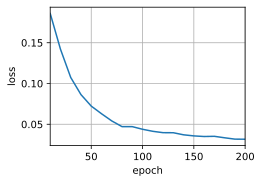

In [51]:
# 直接调用训练方法
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 二、测试

In [52]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

In [53]:
for eng, fra in zip(engs, fras):
    translation, dec_attention_weights_seq = d2l.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}', f'bleu{d2l.bleu(translation, fra, k=2):.3f}')

go . => va ! bleu1.000
i lost . => j'ai perdu . bleu1.000
he's calm . => il est calme . bleu1.000
i'm home . => je suis chez moi . bleu1.000
